RetailHero Uplift Modeling
==========================

Задача на uplift-моделирование. Необходимо отранжировать клиентов по убыванию эффективности коммуникации.

Страница соревнования: https://retailhero.ai/c/uplift_modeling/

Доступные данные:
- data/clients.csv — информация о клиентах
- data/products.csv — информация о товарах
- data/purchases.csv — история покупок клиентов до смс кампании
- data/uplift_train.csv — обучающая выборка клиентов, информация о коммуникации и конверсии
- data/uplift_test.csv — тестовые клиенты, для которых необходимо оценить uplift

In [ ]:
import pandas as pd
import numpy as np
seed = 42
np.random.seed(seed)

import seaborn as sns 
import matplotlib.pyplot as plt 
# !pip install eli5
import eli5
from eli5.sklearn import PermutationImportance


import zipfile
# zipfile.ZipFile('/content/drive/MyDrive/Data/retailhero-uplift.zip').extractall('.')
import warnings
warnings.filterwarnings("ignore")

import time
from tqdm import tqdm
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from lightgbm.sklearn import LGBMClassifier
# !pip install catboost
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# !pip install scikit-uplift
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from sklift.models import ClassTransformation
from sklift.models import TwoModels

In [ ]:
purchases = pd.read_csv('/content/data/purchases.csv', index_col='client_id')

In [ ]:
purchases.transaction_datetime = pd.to_datetime(purchases.transaction_datetime)

In [ ]:
clients = pd.read_csv('/content/data/clients.csv', index_col='client_id')
products = pd.read_csv('/content/data/products.csv', index_col='product_id')

In [ ]:
for col in purchases.columns:
    print(col, len(purchases[col].unique()))

client_id 400162
transaction_id 8045201
transaction_datetime 4260251
regular_points_received 2224
express_points_received 13
regular_points_spent 1147
express_points_spent 78
purchase_sum 258231
store_id 13882
product_id 42530
product_quantity 166
trn_sum_from_iss 3395
trn_sum_from_red 1441


In [ ]:
purchases.isna().any()

transaction_id             False
transaction_datetime       False
regular_points_received    False
express_points_received    False
regular_points_spent       False
express_points_spent       False
purchase_sum               False
store_id                   False
product_id                 False
product_quantity           False
trn_sum_from_iss           False
trn_sum_from_red            True
dtype: bool

In [ ]:
purchases.head()

,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red
client_id,,,,,,,,,,,,
000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,9a80204f78,2.0,80.0,NaN
000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,da89ebd374,1.0,65.0,NaN
000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,0a95e1151d,1.0,24.0,NaN
000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,4055b15e4a,2.0,50.0,NaN
000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,a685f1916b,1.0,22.0,NaN


In [ ]:
clients.head()

,first_issue_date,first_redeem_date,age,gender
client_id,,,,
000012768d,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U
000036f903,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F
000048b7a6,2018-12-15 13:33:11,NaN,68,F
000073194a,2017-05-23 12:56:14,2017-11-24 11:18:01,60,F
00007c7133,2017-05-22 16:17:08,2018-12-31 17:17:33,67,U


In [ ]:
clients.isna().any()

first_issue_date     False
first_redeem_date     True
age                  False
gender               False
dtype: bool

In [ ]:
products.head()

,level_1,level_2,level_3,level_4,segment_id,brand_id,vendor_id,netto,is_own_trademark,is_alcohol
product_id,,,,,,,,,,
0003020d3c,c3d3a8e8c6,c2a3ea8d5e,b7cda0ec0c,6376f2a852,123.0,394a54a7c1,9eaff48661,0.400,0,0
0003870676,e344ab2e71,52f13dac0c,d3cfe81323,6dc544533f,105.0,acd3dd483f,10486c3cf0,0.680,0,0
0003ceaf69,c3d3a8e8c6,f2333c90fb,419bc5b424,f6148afbc0,271.0,f597581079,764e660dda,0.500,0,0
000701e093,ec62ce61e3,4202626fcb,88a515c084,48cf3d488f,172.0,54a90fe769,03c2d70bad,0.112,0,0
0007149564,e344ab2e71,52f13dac0c,d3cfe81323,6dc544533f,105.0,63417fe1f3,f329130198,0.600,0,0


In [ ]:
purchases['avg_spent_on_product'] = purchases.product_id.map(purchases.groupby('product_id')['trn_sum_from_iss'].mean())


# Извлечение и сбор признаков

In [ ]:
features = pd.DataFrame(index=clients.client_id)

In [ ]:
ohe = OneHotEncoder(sparse=False)
features[['F', 'M', 'U']] = ohe.fit_transform(clients.gender.values.reshape(-1,1))

In [ ]:
temp = {
        'first_transaction' : [],
        'last_transaction' : [],
        'delta_trasaction' : [],
}

In [ ]:
for id in tqdm(purchases.index.unique(), position=0):
    try:
        fst_t = (purchases.transaction_datetime.loc[id].tolist()[0] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
        lst_t = (purchases.transaction_datetime.loc[id].tolist()[-1] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
    except AttributeError:
        fst_t = (purchases.transaction_datetime.loc[id] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
        lst_t = (purchases.transaction_datetime.loc[id] -  pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

    temp['first_transaction'] += [fst_t]
    temp['last_transaction'] += [lst_t]
    temp['delta_trasaction'] += [lst_t - fst_t]

100%|██████████| 400162/400162 [04:58<00:00, 1341.43it/s]


In [ ]:
temp['variety_of_products'] = []
temp['favorite_product'] = []
temp['favorite_store'] = []

In [ ]:
for id in tqdm(purchases.index.unique(), position=0):
    try:
        var_of_prod = purchases.loc[id].product_id.drop_duplicates().size
    except AttributeError:
        var_of_prod = 1
    try:
        fav_prod = purchases.loc[id, ['product_id', 'product_quantity']].groupby('product_id').sum()
        fav_prod = fav_prod[fav_prod.product_quantity == fav_prod.max().tolist()[0]].index[0]
    except TypeError:
        fav_prod = purchases.loc[id, ['product_id', 'product_quantity']].product_id
    try:   
        fav_store = purchases.loc[id, ['transaction_datetime', 'store_id']].drop_duplicates().groupby('store_id').count()
        fav_store = fav_store[fav_store.transaction_datetime == fav_store.max().tolist()[0]].index[0]
    except TypeError:
        fav_store = purchases.loc[id, ['transaction_datetime', 'store_id']].store_id
    temp['variety_of_products'] += [var_of_prod]
    temp['favorite_product'] += [fav_prod]
    temp['favorite_store'] += [fav_store]

100%|██████████| 400162/400162 [1:05:19<00:00, 102.09it/s]


In [ ]:
err_purchase_sum = purchases[['transaction_id', 'trn_sum_from_iss']].groupby(['client_id']).sum().trn_sum_from_iss.to_numpy() - \
                   purchases[['transaction_id', 'purchase_sum']].drop_duplicates().groupby(['client_id']).sum().purchase_sum.to_numpy()

total_exp_points_spent = purchases[['transaction_id', 'regular_points_spent']].drop_duplicates().groupby('client_id').sum().regular_points_spent.tolist()
total_reg_points_spent = purchases[['transaction_id', 'express_points_spent']].drop_duplicates().groupby('client_id').sum().express_points_spent.tolist()
total_exp_points_earned = purchases[['transaction_id', 'express_points_received']].drop_duplicates().groupby('client_id').sum().express_points_received.tolist()
total_reg_points_earned = purchases[['transaction_id', 'regular_points_received']].drop_duplicates().groupby('client_id').sum().regular_points_received.tolist()
total_spent = purchases[['transaction_id', 'purchase_sum']].drop_duplicates().groupby('client_id').sum().purchase_sum.tolist()
total_transactions = purchases.transaction_id.drop_duplicates().groupby('client_id').count().tolist()
avg_transaction_value = purchases[['transaction_id', 'purchase_sum']].groupby('client_id').mean().purchase_sum.tolist()

In [ ]:
first_issue_unixtime = (pd.to_datetime(clients['first_issue_date']) - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
first_redeem_unixtime = (pd.to_datetime(clients['first_redeem_date']) - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
features = features.assign(**{
    'age' : clients['age'].tolist(),
    'first_issue_time' : first_issue_unixtime.fillna(0).tolist(),
    'first_redeem_time' : first_redeem_unixtime.fillna(0).tolist(),
    'issue_redeem_delay' : (first_redeem_unixtime - first_issue_unixtime).fillna(0).tolist(),
    'total_spent' : total_spent,
    'err_purchase_sum' : err_purchase_sum,
    'total_transactions' : total_transactions,
    'avg_transaction_value' : avg_transaction_value,
    'total_exp_points_spent' : total_exp_points_spent,
    'total_reg_points_spent' : total_reg_points_spent,
    'total_exp_points_earned' : total_exp_points_earned,
    'total_reg_points_earned' : total_reg_points_earned})
features = features.assign(**temp)

In [ ]:
# Используем частотное кодирование для категориальных переменных.
product_fr = features.groupby('favorite_product').size()/len(features)
features.favorite_product = features.favorite_product.map(product_fr)
store_fr = features.groupby('favorite_store').size()/len(features)
features.favorite_store = features.favorite_store.map(store_fr)

In [ ]:
features.head()

,F,M,U,age,first_issue_time,first_redeem_time,issue_redeem_delay,total_spent,err_purchase_sum,total_transactions,avg_transaction_value,total_exp_points_spent,total_reg_points_spent,total_exp_points_earned,total_reg_points_earned,first_transaction,last_transaction,delta_trasaction,variety_of_products,favorite_product,favorite_store
client_id,,,,,,,,,,,,,,,,,,,,,
000012768d,0.0,0.0,1.0,45,1501947648,1.515094e+09,13146559.0,2803.00,2.00,4,784.788462,0.0,0.0,0.0,25.7,1543648365,1552575707,8927342,46,0.033239,0.000025
000036f903,1.0,0.0,0.0,72,1491832463,1.492951e+09,1118613.0,9805.00,5.00,32,362.746914,0.0,0.0,60.0,54.9,1543402116,1552818577,9416461,96,0.000005,0.000072
000048b7a6,1.0,0.0,0.0,68,1544880791,0.000000e+00,0.0,3772.00,-155.00,8,530.785714,0.0,0.0,0.0,26.5,1544869991,1552386499,7516508,44,0.001332,0.000067
000073194a,1.0,0.0,0.0,60,1495544174,1.511522e+09,15978107.0,9601.40,-87.40,17,764.877073,-96.0,0.0,0.0,74.9,1543143380,1552729281,9585901,68,0.000045,0.000187
00007c7133,0.0,0.0,1.0,67,1495469828,1.546277e+09,50806825.0,6719.84,-231.84,11,650.586988,-240.0,0.0,0.0,56.6,1543072164,1551716610,8644446,64,0.000102,0.000070


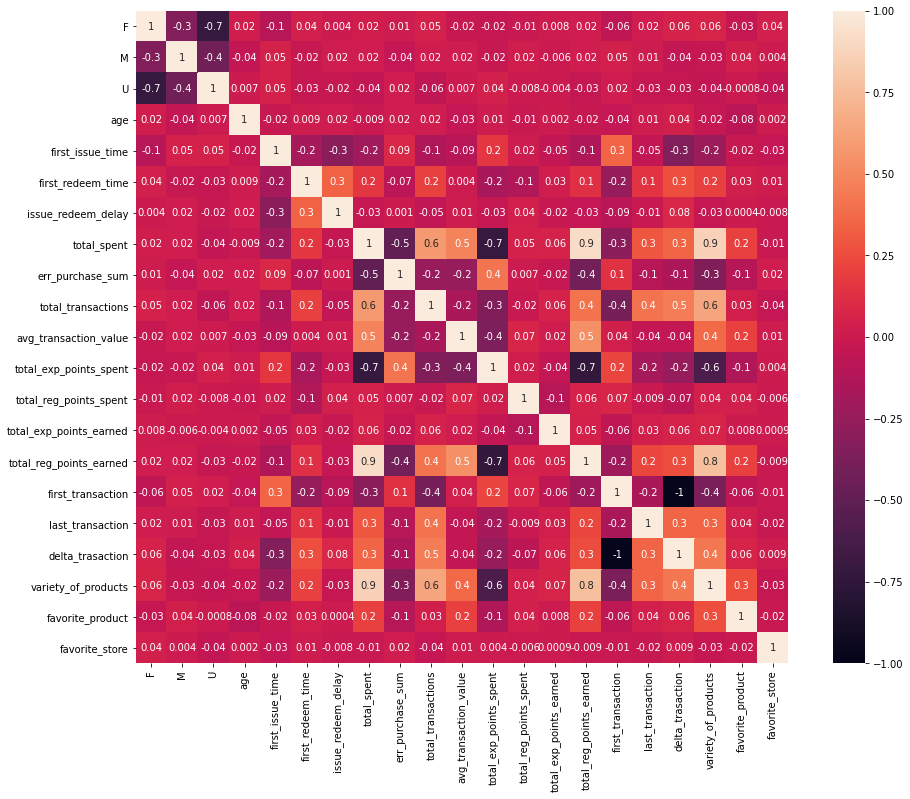

In [ ]:
c_matrix = features.corr()
plt.figure(figsize = (16, 12)) 
sns.heatmap(c_matrix, vmin=-1, annot=True, fmt='.1g', square=True) 
plt.show()

# Реализация простого способа построения uplift-модели.


In [ ]:
def uplift_fit_predict(model, X_train, treatment_train, target_train, X_test):

    """

    Обучаем два бинарных классификатора, которые оценивают вероятность target для клиента:
    1. с которым была произведена коммуникация (treatment=1)
    2. с которым не было коммуникации (treatment=0)
    
    В качестве оценки uplift для нового клиента берется разница оценок вероятностей:
    Predicted Uplift = P(target|treatment=1) - P(target|treatment=0)
    """
    
    X_treatment, y_treatment = X_train[treatment_train == 1, :], target_train[treatment_train == 1]
    X_control, y_control = X_train[treatment_train == 0, :], target_train[treatment_train == 0]
    model_treatment = clone(model).fit(X_treatment, y_treatment)
    model_control = clone(model).fit(X_control, y_control)
    predict_treatment = model_treatment.predict_proba(X_test)[:, 1]
    predict_control = model_control.predict_proba(X_test)[:, 1]
    predict_uplift = predict_treatment - predict_control

    perm_treatment = PermutationImportance(clone(model).fit(X_treatment, y_treatment), random_state=1111).fit(X_treatment, y_treatment)
    display(eli5.show_weights(perm_treatment, feature_names=features.columns.tolist()))
    perm_control = PermutationImportance(clone(model).fit(X_control, y_control), random_state=1111).fit(X_treatment, y_treatment)
    display(eli5.show_weights(perm_control, feature_names=features.columns.tolist()))


    return predict_uplift


def uplift_score(prediction, treatment, target, rate=0.3):
    """
    Подсчет Uplift Score
    """
    order = np.argsort(-prediction)
    treatment_n = int((treatment == 1).sum() * rate)
    treatment_p = target[order][treatment[order] == 1][:treatment_n].mean()
    control_n = int((treatment == 0).sum() * rate)
    control_p = target[order][treatment[order] == 0][:control_n].mean()
    score = treatment_p - control_p
    return score

In [ ]:
uplift_test = pd.read_csv('/content/data/uplift_test.csv', index_col='client_id')
uplift_train = pd.read_csv('/content/data/uplift_train.csv', index_col='client_id')

In [ ]:
indices_train = uplift_train.index
indices_test = uplift_test.index
indices_learn, indices_valid = train_test_split(uplift_train.index, test_size=0.3, random_state=1111)

# Оценка качества на валидации

In [ ]:
valid_uplift = uplift_fit_predict(
    model=GradientBoostingClassifier(random_state=1111, verbose=False),
    X_train=features.loc[indices_learn, :].fillna(0).values,
    treatment_train=uplift_train.loc[indices_learn, 'treatment_flg'].values,
    target_train=uplift_train.loc[indices_learn, 'target'].values,
    X_test=features.loc[indices_valid, :].fillna(0).values,
)
valid_score = uplift_score(
    valid_uplift,
    treatment=uplift_train.loc[indices_valid, 'treatment_flg'].values,
    target=uplift_train.loc[indices_valid, 'target'].values,
)
print('Validation score:', valid_score)

Weight,Feature
0.1099 ± 0.0029,total_transactions
0.0227 ± 0.0014,last_transaction
0.0143 ± 0.0011,first_redeem_time
0.0037 ± 0.0005,first_transaction
0.0029 ± 0.0010,age
0.0024 ± 0.0006,total_reg_points_spent
0.0022 ± 0.0005,first_issue_time
0.0020 ± 0.0008,avg_transaction_value
0.0009 ± 0.0008,total_reg_points_earned
0.0005 ± 0.0006,issue_redeem_delay


Weight,Feature
0.1115 ± 0.0031,total_transactions
0.0251 ± 0.0013,last_transaction
0.0124 ± 0.0006,first_redeem_time
0.0019 ± 0.0005,first_transaction
0.0011 ± 0.0006,delta_trasaction
0.0010 ± 0.0006,issue_redeem_delay
0.0010 ± 0.0011,first_issue_time
0.0007 ± 0.0006,age
0.0003 ± 0.0003,total_exp_points_spent
0.0002 ± 0.0004,avg_transaction_value


Validation score: 0.07299188979002336


Добавленные признаки добавили 0.02 на валидации простого способа построения модели, относительно предоставленного примера решения. 
Попробуем другие подходы, используя библиотеку sklift и выберем лучшую.

In [ ]:
names = ['Random Forest Classifier', 'Bagging Classifier', 
         'Gradient Boosting Classifier',
         'Cat Boost Classifier', 'LGBM Classifier', 'XGB Classifier']

models = [
    RandomForestClassifier(n_jobs=-1, random_state=1111),
    BaggingClassifier(n_jobs=-1, random_state=1111),
    GradientBoostingClassifier(random_state=1111, verbose=False),
    CatBoostClassifier(n_estimators=100, max_depth=6, random_state=1111, verbose=False),
    LGBMClassifier(n_estimators=100, max_depth=6, n_jobs=-1, random_state=1111),
    XGBClassifier(n_estimators=100, max_depth=6, n_jobs=-1, random_state=1111)
    ]

results = {
    'model' : [],
    'approach': [],
    'uplift': []
    }

X_train = features.loc[indices_learn, :]
treatment_train = uplift_train.loc[indices_learn, 'treatment_flg']
y_train = uplift_train.loc[indices_learn, 'target']

X_val = features.loc[indices_valid, :]
treatment_val = uplift_train.loc[indices_valid, 'treatment_flg']
y_val = uplift_train.loc[indices_valid, 'target']

X_train_full = features.loc[indices_train, :]
treat_train_full = uplift_train.loc[:, 'treatment_flg']
y_train_full = uplift_train.loc[:, 'target']

X_test = features.loc[indices_test, :]

Соло модель

In [ ]:
for name, model in zip(names, models):
    start = time.time()
    print(name)
    sm = SoloModel(model)
    sm = sm.fit(X_train, y_train, treatment_train)

    uplift_sm = sm.predict(X_val)

    sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treatment_val, strategy='by_group', k=0.3)

    results['model'].append(name)
    results['approach'].append('SoloModel')
    results['uplift'].append(sm_score)
    print('Result : {} '.format(sm_score))
    print('Duration : {} seconds'.format(round(time.time() - start, 2)))
    print('_' * 60)

Random Forest Classifier
Result : 0.05621597600266637 
Duration : 48.02 seconds
____________________________________________________________
Bagging Classifier
Result : 0.04321742028663478 
Duration : 25.61 seconds
____________________________________________________________
Gradient Boosting Classifier
Result : 0.05888234640595491 
Duration : 87.04 seconds
____________________________________________________________
Cat Boost Classifier
Result : 0.05054993889567827 
Duration : 6.51 seconds
____________________________________________________________
LGBM Classifier
Result : 0.0661037662481947 
Duration : 2.97 seconds
____________________________________________________________
XGB Classifier
Result : 0.07276969225641605 
Duration : 29.34 seconds
____________________________________________________________


Трансформация классов

In [ ]:
for name, model in zip(names, models):
    start = time.time()
    print(name)
    ct = ClassTransformation(model) 
    ct = ct.fit(X_train, y_train, treatment_train)

    uplift_ct = ct.predict(X_val)

    ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treatment_val, strategy='by_group', k=0.3)

    results['model'].append(name)
    results['approach'].append('ClassTransformation')
    results['uplift'].append(ct_score)
    print('Result : {} '.format(ct_score))
    print('Duration : {} seconds'.format(round(time.time() - start, 2)))
    print('_' * 60)

Random Forest Classifier
Result : 0.07176980335518279 
Duration : 70.8 seconds
____________________________________________________________
Bagging Classifier
Result : 0.0625486057104766 
Duration : 35.09 seconds
____________________________________________________________
Gradient Boosting Classifier
Result : 0.08221308743472944 
Duration : 86.67 seconds
____________________________________________________________
Cat Boost Classifier
Result : 0.07832463059660033 
Duration : 6.3 seconds
____________________________________________________________
LGBM Classifier
Result : 0.07265859348961234 
Duration : 2.14 seconds
____________________________________________________________
XGB Classifier
Result : 0.07721364292856348 
Duration : 26.8 seconds
____________________________________________________________


Две зависимые модели

In [ ]:
for name, model in zip(names, models):
    start = time.time()
    print(name)

    tm_ctrl = TwoModels(estimator_trmnt=model, estimator_ctrl=clone(model), method='ddr_control')
    tm_ctrl = tm_ctrl.fit(X_train, y_train, treatment_train)

    uplift_tm_ctrl = tm_ctrl.predict(X_val)

    tm_ctrl_score = uplift_at_k(y_true=y_val, uplift=uplift_tm_ctrl, treatment=treatment_val, strategy='by_group', k=0.3)

    results['model'].append(name)
    results['approach'].append('TwoModels_control')
    results['uplift'].append(tm_ctrl_score)
    print('Result : {} '.format(tm_ctrl_score))
    print('Duration : {} seconds'.format(round(time.time() - start, 2)))
    print('_' * 60)

Random Forest Classifier
Result : 0.05277191423175198 
Duration : 45.15 seconds
____________________________________________________________
Bagging Classifier
Result : 0.052216420397733554 
Duration : 22.39 seconds
____________________________________________________________
Gradient Boosting Classifier
Result : 0.07376958115764909 
Duration : 83.25 seconds
____________________________________________________________
Cat Boost Classifier
Result : 0.06177091434285087 
Duration : 7.66 seconds
____________________________________________________________
LGBM Classifier
Result : 0.06288190201088772 
Duration : 3.38 seconds
____________________________________________________________
XGB Classifier
Result : 0.06577046994778357 
Duration : 28.15 seconds
____________________________________________________________


Две независимые модели

In [ ]:
for name, model in zip(names, models):
    start = time.time()
    print(name)
    tm = TwoModels(estimator_trmnt=model, estimator_ctrl=clone(model), method='vanilla')
    tm = tm.fit( X_train, y_train, treatment_train)

    uplift_tm = tm.predict(X_val)

    tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treatment_val, strategy='by_group', k=0.3)

    results['model'].append(name)
    results['approach'].append('TwoModels')
    results['uplift'].append(tm_score)
    print('Result : {} '.format(tm_score))
    print('Duration : {} seconds'.format(round(time.time() - start, 2)))
    print('_' * 60)

Random Forest Classifier
Result : 0.060104432840795474 
Duration : 44.78 seconds
____________________________________________________________
Bagging Classifier
Result : 0.051660926563715126 
Duration : 21.6 seconds
____________________________________________________________
Gradient Boosting Classifier
Result : 0.07299188979002336 
Duration : 80.69 seconds
____________________________________________________________
Cat Boost Classifier
Result : 0.051327630263304114 
Duration : 7.56 seconds
____________________________________________________________
LGBM Classifier
Result : 0.064215087212532 
Duration : 3.07 seconds
____________________________________________________________
XGB Classifier
Result : 0.0585490501055439 
Duration : 26.75 seconds
____________________________________________________________


In [ ]:
df_results = pd.DataFrame({
    'model': results['model'],
    'approach' : results['approach'],
    'feature_score': results['uplift']
}).set_index(['approach', 'model']).sort_values('feature_score', ascending=False)

df_results

feature_score
approach            model                                      
ClassTransformation Gradient Boosting Classifier       0.082213
                    Cat Boost Classifier               0.078325
                    XGB Classifier                     0.077214
TwoModels_control   Gradient Boosting Classifier       0.073770
TwoModels           Gradient Boosting Classifier       0.072992
SoloModel           XGB Classifier                     0.072770
ClassTransformation LGBM Classifier                    0.072659
                    Random Forest Classifier           0.071770
SoloModel           LGBM Classifier                    0.066104
TwoModels_control   XGB Classifier                     0.065770
TwoModels           LGBM Classifier                    0.064215
TwoModels_control   LGBM Classifier                    0.062882
ClassTransformation Bagging Classifier                 0.062549
TwoModels_control   Cat Boost Classifier               0.061771
TwoModels           Random Forest Classifier           0.060104
SoloModel           Gradient Boosting Classifier       0.058882
TwoModels           XGB Classifier                     0.058549
SoloModel           Random Forest Classifier           0.056216
TwoModels_control   Random Forest Classifier           0.052772
                    Bagging Classifier                 0.052216
TwoModels           Bagging Classifier                 0.051661
                    Cat Boost Classifier               0.051328
SoloModel           Cat Boost Classifier               0.050550
                    Bagging Classifier                 0.043217

Данные результатов разных подходов и моделей, показывают, что в данном случае лучше всего справляется подход трансформации класса. Выберем его и попробуем улучшить результаты моделей.

# Подготовка предсказаний для тестовых клиентов

In [ ]:
test_uplift = uplift_fit_predict(
    model=GradientBoostingClassifier(random_state=1111, verbose=False),
    X_train=features.loc[indices_train, :].fillna(0).values,
    treatment_train=uplift_train.loc[indices_train, 'treatment_flg'].values,
    target_train=uplift_train.loc[indices_train, 'target'].values,
    X_test=features.loc[indices_test, :].fillna(0).values,
)

df_submission = pd.DataFrame({'uplift': test_uplift}, index=uplift_test.index)
df_submission